# Part 1 

## importing 

In [1]:
import warnings
import os
import sys
import time
import math
import pickle
from pathlib import Path
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from IPython.display import Image, display

# Statistical & Machine Learning Libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import mse, rmse
from patsy import dmatrices

from sklearn.model_selection import (
    train_test_split, cross_val_score, KFold, RepeatedKFold, 
    GridSearchCV, RandomizedSearchCV
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import plot_tree
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.inspection import permutation_importance, PartialDependenceDisplay, partial_dependence
from sklearn.metrics import mean_squared_error, r2_score

# Plotting Libraries
from plotnine import *
from mizani.formatters import percent_format

# Stargazer for Model Output
from stargazer import stargazer

# Suppress warnings
warnings.filterwarnings("ignore")

In [2]:

# data_dir = "/Users/ghadena/Desktop/Business analytics/DA3/DA3/assignment_1/data"
# path = os.path.join(data_dir,'airbnb_madrid_workfile_adj_.csv') 
df = pd.read_csv('https://media.githubusercontent.com/media/ghadena/DA3/refs/heads/main/assignment_1/data/airbnb_madrid_workfile_adj_.csv')
df.head()

,f_room_type,f_property_type,f_room_type2,f_neighbourhood_cleansed,usd_price_day,p_host_response_rate,n_accommodates,n_bathrooms,n_review_scores_rating,n_number_of_reviews,...,flag_days_since,flag_review_scores_rating,flag_reviews_per_month,flag_n_number_of_reviews,ln_days_since,ln_days_since2,ln_days_since3,n_days_since2,n_days_since3,ln_review_scores_rating
0,Entire,Apartment,Entire/Apt,Universidad,150.0,0,4,1.0,4.64,14,...,0,0,0,0,5.983936,35.807493,214.269759,156816.0,6.209914e+07,1.534714
1,Entire,Apartment,Entire/Apt,Universidad,137.0,0,4,1.0,4.58,31,...,0,0,0,0,5.866468,34.415447,201.897123,123904.0,4.361421e+07,1.521699
2,Entire,Apartment,Entire/Apt,Justicia,244.0,0,6,2.0,4.78,67,...,0,0,0,0,6.587550,43.395815,285.872103,525625.0,3.810781e+08,1.564441
3,Entire,Apartment,Entire/Apt,Argüelles,144.0,0,4,1.0,4.96,387,...,0,0,0,0,7.884200,62.160609,490.086666,7043716.0,1.869402e+10,1.601406
4,Entire,Apartment,Entire/Apt,Entrevías,69.0,0,4,1.0,3.73,11,...,0,0,0,0,6.133398,37.618572,230.729673,211600.0,9.733600e+07,1.316408



## Exploratory Data Analysis (EDA) and Sample Design

Feature engineering and EDA was done in the cleaning script. To ensure data integrity, I first verified that the imported data was correct. After confirming this, I examined the distribution of prices and decided to focus only on apartments with a price below 500.

Reasoning for Price Capping:
1. 99% of apartments are priced below 500, as shown by the quota analysis.
2. When fitting an Ordinary Least Squares (OLS) model, the Y-fit graph revealed that the model performed poorly in predicting prices above 500. This reinforced the decision to cap the prices at 500.

Data Cleaning & Feature Selection:
- I reviewed the data description and shape to understand the dataset structure.
- Identified and dropped columns with only one unique value, as they provided no useful variation.
- Removed the USD price per day column due to data leakage concerns.
- Used a helper function to generate plots visualizing the price distribution and its relationship with key variables.

In [3]:
df.isnull().sum().sum()

0

In [4]:
#We focus on normal apartments, n<8
df = df.loc[lambda x: x["n_accommodates"] < 8]
# and we focus on apartments with a price below 500 
# reasoning: the quantiles show that 99% of the apartments are priced below 500
# also - EDA and the y fit graph showed that the perliminary ols model is not very good at predicting prices above 500
print(df['price'].quantile([0.25, 0.5, 0.75, 0.90, 0.99,1]))
df = df.loc[lambda x: x["price"] < 500]

0.25     60.0
0.50    100.0
0.75    147.0
0.90    210.0
0.99    493.0
1.00    999.0
Name: price, dtype: float64


In [5]:
df.describe()

,usd_price_day,p_host_response_rate,n_accommodates,n_bathrooms,n_review_scores_rating,n_number_of_reviews,n_reviews_per_month,n_minimum_nights,n_beds,n_days_since,...,flag_days_since,flag_review_scores_rating,flag_reviews_per_month,flag_n_number_of_reviews,ln_days_since,ln_days_since2,ln_days_since3,n_days_since2,n_days_since3,ln_review_scores_rating
count,20035.000000,20035.0,20035.000000,20035.000000,20035.000000,20035.000000,20035.000000,20035.000000,20035.000000,20035.000000,...,20035.000000,20035.000000,20035.000000,20035.0,20035.000000,20035.000000,20035.000000,2.003500e+04,2.003500e+04,20035.000000
mean,112.564113,0.0,3.013776,1.247916,4.668570,53.333816,1.947126,7.094085,1.817869,6.280108,...,0.166958,0.166958,0.166958,0.0,6.280108,40.866948,273.155272,1.728531e+06,4.475298e+09,1.533983
std,72.402847,0.0,1.518154,0.579684,0.428186,93.986065,1.832526,17.415449,1.195863,1.194681,...,0.372948,0.372948,0.372948,0.0,1.194681,14.014387,131.903495,3.240157e+06,1.160887e+10,0.135792
min,1.000000,0.0,1.000000,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000
25%,60.000000,0.0,2.000000,1.000000,4.610000,2.000000,0.730000,1.000000,1.000000,5.697093,...,0.000000,0.000000,0.000000,0.0,5.697093,32.456874,184.909847,8.820900e+04,2.619807e+07,1.528228
50%,99.000000,0.0,3.000000,1.000000,4.760000,15.000000,1.460000,2.000000,1.000000,6.388561,...,0.000000,0.000000,0.000000,0.0,6.388561,40.813717,260.740936,3.528360e+05,2.095846e+08,1.560248
75%,145.000000,0.0,4.000000,1.000000,4.880000,61.000000,2.560000,3.000000,2.000000,7.025094,...,0.000000,0.000000,0.000000,0.0,7.025094,49.351941,346.702013,1.262252e+06,1.418141e+09,1.585145
max,499.000000,0.0,7.000000,12.000000,5.000000,1092.000000,41.220000,364.000000,40.000000,8.546364,...,1.000000,1.000000,1.000000,0.0,8.546364,73.040330,624.229217,2.649161e+07,1.363523e+11,1.609438


In [6]:
df.shape

(20035, 244)

In [7]:
# Identify columns with only one unique value
columns_to_drop = [col for col in df.columns if df[col].nunique() == 1]
print(f"Columns to drop: {columns_to_drop}")

# Drop the identified columns
df = df.drop(columns=columns_to_drop)
print("Dropped columns with only one unique value.")

#print(data_train[["price", "usd_price_day"]].corr())
#df = df.drop(columns=["d_unnamed:59", "usd_price_day"])
df = df.drop(columns=["usd_price_day"])

Columns to drop: ['p_host_response_rate', 'd_free_residential_garage_on_premises_2_spaces', 'd_friday_included_with_your_stay', 'd_monday', 'd_peque_o_para_pizza', 'd_thursday_included_with_your_stay', 'flag_n_number_of_reviews']
Dropped columns with only one unique value.


In [8]:
#print(df.d_airconditioning.value_counts().sum())
print(df.d_view.value_counts())
df.shape

d_view
1    16803
0     3232
Name: count, dtype: int64


(20035, 236)

In [9]:
def price_diff_by_variables(df, factor_var, dummy_var, factor_lab, dummy_lab):
    # Calculate statistics same way as before
    stats = df.groupby([factor_var, dummy_var]).agg(
        Mean=("price", np.mean), 
        sd=("price", np.std), 
        size=("price", "size")
    )
    stats["se"] = stats["sd"] / stats["size"] ** (1/2)
    stats["Mean_l"] = stats["Mean"] - (1.96 * stats["se"])
    stats["Mean_u"] = stats["Mean"] + (1.96 * stats["se"])
    stats = stats.drop(["sd", "size"], axis=1).reset_index()

    # Create the plot using seaborn
    # plt.figure(figsize=(10, 6))
    plt.figure()

    # Create bar plot
    ax = sns.barplot(
        data=stats,
        x=stats.columns[0],
        y='Mean',
        hue=stats.columns[1],
        palette=['indianred', 'steelblue'],
        ci=None
    )

    # Add error bars
    for i, group in enumerate(stats[stats.columns[1]].unique()):
        group_data = stats[stats[stats.columns[1]] == group]
        x = np.arange(len(group_data))

        # Adjust x positions for dodge effect
        x = x + 0.2 if i == 1 else x - 0.2
        plt.errorbar(
            x=x, 
            y=group_data['Mean'],
            yerr=[(group_data['Mean'] - group_data['Mean_l']), 
                  (group_data['Mean_u'] - group_data['Mean'])],
            fmt='none',
            color='black',
            capsize=3
        )

    # Customize the plot
    plt.xlabel(factor_lab)
    plt.ylabel('Mean Price')

    # Customize legend
    plt.legend(
        title=dummy_lab,
        bbox_to_anchor=(0.5, 1.15),
        loc='center',
        ncol=2,
        fontsize=10,
        title_fontsize=10
    )

    # Remove grid
    ax.grid(False)
    plt.show()

    return plt



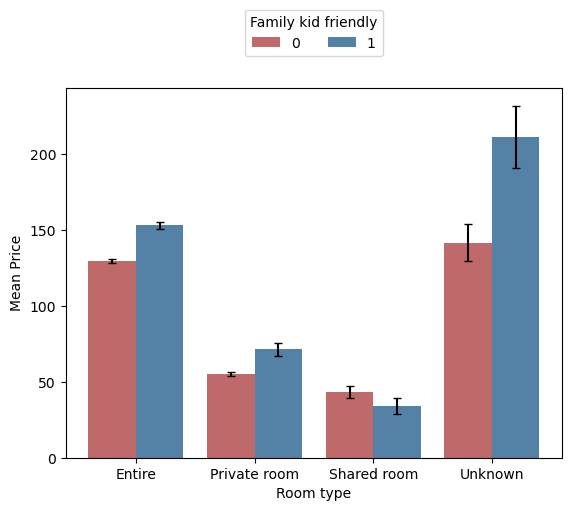

In [10]:
price_diff_by_variables(df,"f_room_type","d_child_friendly","Room type", "Family kid friendly");

## Training and Holdout Sets

For model training, I implemented a 70-30 train-test split.

Feature Engineering:
- Created basic variables, review-related variables, and amenity-based features.
- Generated interaction terms, including interactions with neighborhoods.
- Cleaned column names to remove special characters for consistency.

Model Preparation:
- Initialized a list to store model results.
- Defined a universal design matrix:
- Predictors E: Includes interaction terms, used for OLS and LASSO models.
- Predictors 2: Full list of predictors without interaction terms, used for tree-based models.


In [11]:
data_train, data_test = train_test_split(df, train_size=0.7, random_state=42)
data_train.shape, data_test.shape

((14024, 236), (6011, 236))

In [12]:
basic_vars = [
    "n_accommodates",
    "n_beds",
    "n_days_since",
    "f_property_type",
    "f_room_type",
    "f_bathroom",
    "f_neighbourhood_cleansed",
]

reviews = [
    "n_number_of_reviews",
    "n_review_scores_rating",
    "flag_review_scores_rating",
]

amenities = [col for col in df if col.startswith("d_")]

X1 = [
    "n_accommodates:f_property_type",
    "f_room_type:f_property_type",
    "n_accommodates:n_bathrooms", 
    "n_accommodates:f_room_type", 
    #"n_accommodates:d_airconditioning", 
    #"n_review_scores_rating:d_pets_allowed", 
    "n_review_scores_rating:d_child_friendly", 
    "n_review_scores_rating:d_free_parking",
    "n_accommodates:d_housekeeping_included",
    "n_review_scores_rating:d_housekeeping_included",
    "d_housekeeping_included:f_property_type",
]
# with boroughs
X2 = [
    "f_property_type:f_neighbourhood_cleansed",
    "f_room_type:f_neighbourhood_cleansed",
    "n_accommodates:f_neighbourhood_cleansed",
]

predictors_1 = basic_vars
predictors_2 = basic_vars + reviews + amenities
predictors_E = basic_vars + reviews + amenities + X1 + X2

In [13]:
import re
from patsy import dmatrices

# Clean column names to remove special characters
data_train.columns = data_train.columns.str.replace(r"[^\w\s]", "_", regex=True)

# Update predictors_2 to match cleaned column names
predictors_1_cleaned = [re.sub(r"[^\w\s]", "_", col) for col in predictors_1]
predictors_2_cleaned = [re.sub(r"[^\w\s]", "_", col) for col in predictors_2]
predictors_E_cleaned = [re.sub(r"[^\w\s:]", "_", col) for col in predictors_E]

# Ensure the cleaned column names are in the dataframe
data_train = data_train.rename(columns=dict(zip(predictors_2, predictors_2_cleaned)))


In [14]:
# Initialize a list to store model results
results_list = []

In [15]:
# ----------------------------
# 📌 Define universal design matrix code 
# ----------------------------
# For models using predictors_E (OLS & LASSO):
_, X_train_full_E = dmatrices("price ~ " + " + ".join(predictors_E), data_train, return_type="dataframe")
train_cols = X_train_full_E.columns
print("Universal design matrix for predictors_E shape:", X_train_full_E.shape)

# For models using predictors_2 (CART, RF, Boosting):
y_train_full_2, X_train_full_2 = dmatrices("price ~ " + " + ".join(predictors_2), data_train, return_type="dataframe")
train_cols_2 = X_train_full_2.design_info.column_names
print("Universal design matrix for predictors_2 shape:", X_train_full_2.shape)

Universal design matrix for predictors_E shape: (14024, 1656)
Universal design matrix for predictors_2 shape: (14024, 348)


## Ordinary Least Squares (OLS) Modeling

To systematically evaluate model performance, I created a for loop that iterates through the defined predictor sets, training an OLS model for each configuration and extracting key performance metrics.

Model Training & Evaluation:

Prepared the Design Matrix
- Created the design matrix for the test data and re-indexed it to ensure it aligned with the training columns.  
- This step was crucial for avoiding mismatched predictors between train and test sets.  

Model Fitting & Performance Metrics
- Fitted the OLS model on the training data.  
- Computed the following metrics:  
  - Train RMSE  
  - Cross-validated RMSE (5-fold)  
  - Test RMSE  
  - Test R²  

Cross-Validation & Ridge Regularization
- Used 5-fold cross-validation to compute a more robust estimate of the model’s generalization error.  
- Ridge regression was included for stability and potential outlier handling—though its exact role in this analysis needs further clarification.  

Comparing Model Performance
- Stored all results in a horse race table to compare different models.  
- As expected, the third model—which included interaction terms and all available variables—performed the best, achieving:  
  - Test RMSE: 50.05  
  - Test R²: 0.539  

Prediction Performance & Visualization
- **Actual vs. Predicted Plot**:  
  - The scatter plot of actual versus predicted values showed a strong alignment along the 45-degree line, indicating a good fit.  
  - The model did not exhibit a strong bias toward over- or under-prediction.  
  - However, at higher price levels (~300 per night and above), predictions deviated more from the perfect fit, showing greater dispersion.  

Possible Explanation for Dispersion at Higher Prices
- This increased variability in predictions at higher price points likely stems from:  
  1. Fewer data points in that price range, leading to more uncertainty.  
  2. Greater heterogeneity in high-priced apartments, making price predictions harder.  

In [16]:
import pandas as pd
import numpy as np
import time
import statsmodels.api as sm
from patsy import dmatrices
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# ----------------------------
# 📌 Define Predictor Sets for OLS Models
# ----------------------------
predictors_list = [
    predictors_1_cleaned,
    predictors_2_cleaned,
    predictors_E_cleaned
]

# ----------------------------
# 📌 Loop Through Predictor Sets, Train OLS Model, and Extract Metrics
# ----------------------------
for i, predictors_cleaned in enumerate(predictors_list, start=1):
    start_time = time.time()  # Start timer

    # ----------------------------
    # 📌 Create Design Matrices for Training Data using the current predictor set.
    #    dmatrices returns both y and X; no need to define y separately.
    # ----------------------------
    y_train, X_train = dmatrices("price ~ " + " + ".join(predictors_cleaned), data_train, return_type="dataframe")
    
    # Save the universal training columns for this predictor set.
    train_cols = X_train.columns  
    print(f"Universal training columns for OLS Model {i}: {list(train_cols)}")
    
    # ----------------------------
    # 📌 Create Design Matrices for Test Data
    # ----------------------------
    y_test, X_test = dmatrices("price ~ " + " + ".join(predictors_cleaned), data_test, return_type="dataframe")
    y_test = y_test.values.ravel()  # Convert y_test to a 1D array
    
    # ----------------------------
    # 📌 Reindex X_test to Ensure It Matches the Training Columns
    # ----------------------------
    X_test = X_test.reindex(columns=train_cols, fill_value=0)
    print(f"After reindexing, X_test shape for OLS Model {i}: {X_test.shape} (should match {len(train_cols)} columns)")
    
    # ----------------------------
    # 📌 Fit the OLS Model
    # ----------------------------
    model = sm.OLS(y_train, X_train).fit()

    # Compute Execution Time
    execution_time = time.time() - start_time

    # ----------------------------
    # 📌 Compute Model Performance Metrics
    # ----------------------------
    train_rmse = np.sqrt(model.mse_resid)  # Train RMSE from model's residuals
    y_pred_test = model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_r_squared = r2_score(y_test, y_pred_test)

    # ----------------------------
    # 📌 Compute Cross-Validated RMSE (5-Fold) Using Ridge for Stability
    # ----------------------------
    scaler_cv = StandardScaler()
    X_train_scaled = scaler_cv.fit_transform(X_train)
    ridge_reg = Ridge(alpha=1.0)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_rmse_scores = np.sqrt(-cross_val_score(
        ridge_reg, X_train_scaled, y_train.values.ravel(), cv=kf, scoring="neg_mean_squared_error"
    ))
    cv_rmse = np.mean(cv_rmse_scores)

    # ----------------------------
    # 📌 Append Results to Horse Race Table
    # ----------------------------
    results_list.append({
        "Model": f"OLS Model {i}",
        "Execution Time (s)": round(execution_time, 4),
        "Num Predictors": len(predictors_cleaned),  # Number of predictors from the formula
        "Train RMSE": round(train_rmse, 4),
        "CV RMSE (5-Fold)": round(cv_rmse, 4),
        "Test RMSE": round(test_rmse, 4),
        "Test R-squared": round(test_r_squared, 4),
    })

    print(f"OLS Model {i} results: Test RMSE = {test_rmse:.4f}, Test R² = {test_r_squared:.4f}")

print("OLS models added to results_list.")

Universal training columns for OLS Model 1: ['Intercept', 'f_property_type[T.Apartment]', 'f_property_type[T.Hostel]', 'f_property_type[T.Hotel/Serviced Stay]', 'f_property_type[T.House]', 'f_property_type[T.Traditional Stay]', 'f_property_type[T.Unknown]', 'f_room_type[T.Private room]', 'f_room_type[T.Shared room]', 'f_room_type[T.Unknown]', 'f_bathroom[T.[0, 1)]', 'f_bathroom[T.[1, 2)]', 'f_bathroom[T.[2, 10)]', 'f_neighbourhood_cleansed[T.Acacias]', 'f_neighbourhood_cleansed[T.Adelfas]', 'f_neighbourhood_cleansed[T.Aeropuerto]', 'f_neighbourhood_cleansed[T.Aguilas]', 'f_neighbourhood_cleansed[T.Alameda de Osuna]', 'f_neighbourhood_cleansed[T.Almagro]', 'f_neighbourhood_cleansed[T.Almenara]', 'f_neighbourhood_cleansed[T.Almendrales]', 'f_neighbourhood_cleansed[T.Aluche]', 'f_neighbourhood_cleansed[T.Ambroz]', 'f_neighbourhood_cleansed[T.Amposta]', 'f_neighbourhood_cleansed[T.Apostol Santiago]', 'f_neighbourhood_cleansed[T.Arapiles]', 'f_neighbourhood_cleansed[T.Aravaca]', 'f_neighbou

Test design matrix shape: (6011, 1656)


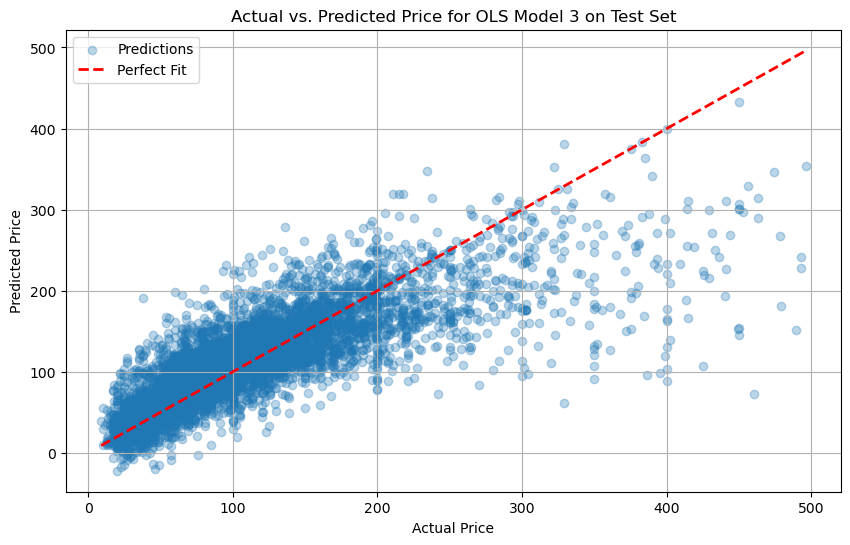

In [17]:
# ----------------------------
# 📌 Create Design Matrices for Model 3 (Test Set)
# ----------------------------
y_test, X_test = dmatrices("price ~ " + " + ".join(predictors_E_cleaned), data_test, return_type="dataframe")

# Reindex X_test using universal training columns (train_cols)
X_test = X_test.reindex(columns=train_cols, fill_value=0)
print("Test design matrix shape:", X_test.shape)

# ----------------------------
# 📌 Fit the OLS Model for Model 3
# ----------------------------
model_ols = sm.OLS(y_test, X_test).fit()

# ----------------------------
# 📌 Use the Pre-trained OLS Model for Model 3
# ----------------------------
# DO NOT re-fit the model on test data; use the model trained on training data.
y_pred = model_ols.predict(X_test)

# ----------------------------
# 📌 Plot Actual vs. Predicted Values
# ----------------------------
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3, label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Perfect Fit")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted Price for OLS Model 3 on Test Set")
plt.legend()
plt.grid(True)
plt.show()

## LASSO Regression

For regularization, I implemented LASSO regression, which is equivalent to the Elastic Net model with an L1 ratio of 1.

Understanding L1 Ratio = 1
- The L1 ratio controls the balance between L1 (LASSO) and L2 (Ridge) regularization.  
- Setting L1 ratio = 1 makes it pure LASSO, meaning the model performs feature selection by shrinking some coefficients to zero.  

 Hyperparameter Tuning (Alpha Selection):

 Grid Search Setup
- Conducted a grid search over 100 values of alpha:  

  \[
  \alpha = \frac{i}{100}, \quad \text{for } i \in [1, 101]
  \]

- This resulted in 100 different models being trained.  

Optimal Alpha Selection
- The best alpha was 0.21, selected using GridSearchCV, as it provided the lowest validation RMSE.  
- A small alpha means less regularization, allowing the model to retain more features and capture more complex relationships.  
- This prevented underfitting by keeping important predictors rather than aggressively shrinking coefficients.  

Model Training & Performance Evaluation
- Standardized the design matrix using a scaler before fitting the model.  
- Performed cross-validation to ensure robust performance.  
- Final model performance:  
  - Root Mean Squared Error (RMSE): 47.24  
  - Better than OLS (which had an RMSE of 50.05).  

Feature Selection & Interpretation
- The LASSO model used 517 coefficients out of 1,656 available predictors (likely due to feature expansion via one-hot encoding).  
- Top 10 most important features included:  
  1. Interaction term: Number of accommodates × Number of bathrooms  
  2. Room type = Private Room (negative impact on price)  
  3. Neighborhood = Universidad (Madrid) (positive impact)  
  4. Neighborhood = Recoletos (Madrid) (positive impact)  
  5. Number of reviews (negative impact)  
  6. Number of accommodates (positive impact)  
  7-10. Four additional neighborhoods that increased price  

Feature Selection Summary
- LASSO dropped 1,139 features, keeping only 517 variables that contributed meaningfully to price prediction.  
- The presence of interaction terms and neighborhood effects suggests that the model effectively captured important relationships in the dataset.  

In [18]:
import pandas as pd
import numpy as np
import time
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from patsy import dmatrices

# ----------------------------
# 📌 Start Timer
# ----------------------------
start_time = time.time()

# ----------------------------
# 📌 Define and Tune LASSO Model (Using ElasticNet with L1 Ratio = 1)
# ----------------------------
lasso_model = ElasticNet(l1_ratio=1, fit_intercept=True)  # Pure LASSO (L1 Regularization)
#lasso_param_grid = {'alpha': [0.21]}  # Using a fixed parameter for now
# This is the initial search which took 3 minutes to run
lasso_param_grid = {
    "alpha": [i / 100 for i in range(1, 101, 10)]}

lasso_model_cv = GridSearchCV(
    lasso_model,
    lasso_param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=0
)

# ----------------------------
# 📌 Create Design Matrices for Training Data using predictors_E (includes interactions)
# ----------------------------
y_train, X_train = dmatrices("price ~ " + " + ".join(predictors_E), data_train, return_type="dataframe")
# Save the universal training columns for predictors_E:
train_cols = X_train.columns  

# ----------------------------
# 📌 Standardize Features (Essential for LASSO)
# ----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# ----------------------------
# 📌 Fit LASSO Model with Cross-Validation
# ----------------------------
lasso_model_cv.fit(X_train_scaled, y_train.values.ravel())

# ----------------------------
# 📌 Display Best Hyperparameters and CV RMSE
# ----------------------------
print("=" * 50)
print("LASSO Model Training Results")
print(f"Best RMSE Score (CV): {-lasso_model_cv.best_score_:.4f}")
print(f"Best Parameters: {lasso_model_cv.best_params_}")
print("=" * 50)

# ----------------------------
# 📌 Extract Best LASSO Model and Compute Training Performance
# ----------------------------
best_lasso_model = lasso_model_cv.best_estimator_
lasso_rmse_train = (
    pd.DataFrame(lasso_model_cv.cv_results_)
    .loc[lambda x: x.param_alpha == best_lasso_model.alpha]
    .mean_test_score.values[0] * -1
)
num_predictors = np.sum(best_lasso_model.coef_ != 0)

# ----------------------------
# 📌 Execution Time Calculation
# ----------------------------
execution_time = time.time() - start_time

# ----------------------------
# 📌 Prepare Test Data for Prediction using predictors_E
# ----------------------------
y_test, X_test = dmatrices("price ~ " + " + ".join(predictors_E), data_test, return_type="dataframe")
# Reindex X_test to ensure it has exactly the same columns as the training set (train_cols)
X_test = X_test.reindex(columns=train_cols, fill_value=0)
print("Test design matrix shape after reindexing:", X_test.shape)

# ----------------------------
# 📌 Standardize Test Features using the Same Scaler
# ----------------------------
X_test_scaled = scaler.transform(X_test)

# ----------------------------
# 📌 Make Predictions on Test Set
# ----------------------------
y_pred_test = best_lasso_model.predict(X_test_scaled)

# ----------------------------
# 📌 Compute Test RMSE and Test R²
# ----------------------------
test_rmse = np.sqrt(mean_squared_error(y_test.values.ravel(), y_pred_test))
r_squared_test = r2_score(y_test.values.ravel(), y_pred_test)

# ----------------------------
# 📌 Store Results in Horse Race Table
# ----------------------------
results_list.append({
    "Model": "LASSO",
    "Execution Time (s)": round(execution_time, 4),
    "Num Predictors": num_predictors,
    "Train RMSE": round(lasso_rmse_train, 4),
    "CV RMSE (5-Fold)": round(-lasso_model_cv.best_score_, 4),
    "Test RMSE": round(test_rmse, 4),
    "Test R-squared": round(r_squared_test, 4)
})

print("LASSO model results added to results_list.")

LASSO Model Training Results
Best RMSE Score (CV): 47.2379
Best Parameters: {'alpha': 0.21}
Test design matrix shape after reindexing: (6011, 1656)
LASSO model results added to results_list.


In [19]:
import numpy as np

# ----------------------------
# 📌 Count Nonzero Coefficients (Active Features in LASSO)
# ----------------------------
num_nonzero = np.sum(best_lasso_model.coef_ != 0)
total_features = len(best_lasso_model.coef_)

print("=" * 50)
print(f"📌 Number of nonzero coefficients: {num_nonzero} / {total_features}")
print("=" * 50)

# ----------------------------
# 📌 Print Shape of Coefficients (Feature Count After Preprocessing)
# ----------------------------
print(f"LASSO Model Coefficient Shape: {best_lasso_model.coef_.shape}")

# If LASSO is using significantly more features than expected, flag it
if num_nonzero > 226:
    print("LASSO is using more features than expected (Possible One-Hot Encoding, Feature Expansion).")

# ----------------------------
# 📌 Extract & Sort Feature Importances by Absolute Magnitude
# ----------------------------
lasso_feature_importance = dict(zip(train_cols, best_lasso_model.coef_))
lasso_sorted_features = sorted(lasso_feature_importance.items(), key=lambda x: abs(x[1]), reverse=True)

# ----------------------------
# 📌 Print Top 10 Most Important Features
# ----------------------------
print("\n📌 Top 10 Most Important Features in LASSO:")
print("-" * 50)
for rank, (feature, coef) in enumerate(lasso_sorted_features[:10], start=1):
    print(f"{rank}. {feature}: {coef:.4f}")
print("-" * 50)

# ----------------------------
# 📌 Print Features with Coefficients Exactly Zero
# ----------------------------
zero_coef_features = [feature for feature, coef in lasso_sorted_features if coef == 0]

print("\n📌 Features Completely Dropped by LASSO:")
if zero_coef_features:
    print(f"Total Features Dropped: {len(zero_coef_features)}")
    print(f"Example Features: {zero_coef_features[:5]} ... (showing first 5)")
else:
    print("No features were completely dropped.")
print("=" * 50)

📌 Number of nonzero coefficients: 517 / 1656
LASSO Model Coefficient Shape: (1656,)
LASSO is using more features than expected (Possible One-Hot Encoding, Feature Expansion).

📌 Top 10 Most Important Features in LASSO:
--------------------------------------------------
1. n_accommodates:n_bathrooms: 18.8283
2. f_room_type[T.Private room]: -17.2667
3. n_accommodates:f_neighbourhood_cleansed[T.Universidad]: 6.9920
4. n_accommodates:f_neighbourhood_cleansed[T.Recoletos]: 5.9733
5. n_number_of_reviews: -5.8396
6. n_accommodates: 5.4323
7. n_accommodates:f_neighbourhood_cleansed[T.Palacio]: 5.2481
8. n_accommodates:f_neighbourhood_cleansed[T.Goya]: 4.5419
9. n_accommodates:f_neighbourhood_cleansed[T.Castellana]: 4.4647
10. n_accommodates:f_neighbourhood_cleansed[T.Justicia]: 4.4135
--------------------------------------------------

📌 Features Completely Dropped by LASSO:
Total Features Dropped: 1139
Example Features: ['Intercept', 'f_property_type[T.Apartment]', 'f_property_type[T.Hostel]'


## CART Model

I decided to include CART as an optional model for evaluation. 

I defined the model evaluation method and set up the decision tree model. Then, I tested multiple hyperparameter combinations, which took approximately 30 minutes to run. After tuning, the best parameters were:

- Maximum depth: 10
- Minimum impurity decrease: 5
- Minimum samples per leaf: 10
- Splitter: random

I performed a grid search with cross-validation and displayed the selected hyperparameters along with the cross-validated RMSE, which was 51.42. This result was slightly worse than OLS and also worse than LASSO.

I then evaluated the model on the test data. The number of selected features was 25, though they were not true predictors—rather, they were the features chosen by the model.

I visualized the decision tree and found that it prioritized features we expected. For example, private rooms had a higher cost, and the number of accommodates was an important factor.

I also computed feature importance for the CART model. The most influential features included:

- Private room
- Number of bathrooms
- Number of people the property accommodates
- Shared room
- Whether the property was a hotel or serviced apartment
- Several amenities

However, the model appeared to pick up some noise, as it ranked features like having a dryer, free street parking, or an elevator among the top 10 most important variables.

In [ ]:
# ----------------------------
# 📌 Define Model Evaluation Method (5-Fold CV with 1 Repeat)
# ----------------------------
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=20250217)

# ----------------------------
# 📌 Define the Decision Tree Model
# ----------------------------
cart_model = DecisionTreeRegressor(random_state=20250217)

# ----------------------------
# 📌 Define the Best Found Parameter Grid (Pre-selected for Speed)
# ----------------------------
# param_grid = {
#     "max_depth": [10], 
#     "min_impurity_decrease": [5],
#     "min_samples_leaf": [10], 
#     "splitter": ["random"]
# }

# Here is the initial search I ran which took 25 minutes to run 

param_grid = {
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 5, 10],
    "ccp_alpha": [0.0, 0.01, 0.05, 0.1], # Pruning parameter
    "min_impurity_decrease": [1, 5, 10, 25, 45, 65], 
    "splitter": ["best", "random"]}

# ----------------------------
# 📌 Perform Grid Search with Cross-Validation
# ----------------------------
start_time = time.time()  # Start timer

search = GridSearchCV(cart_model, param_grid, scoring="neg_root_mean_squared_error", cv=cv, verbose=0)
# Create design matrices for training data using predictors_2
y_train, X_train = dmatrices("price ~ " + " + ".join(predictors_2), data_train, return_type="dataframe")
# Save the universal training columns for CART (predictors_2)
train_cols_2 = X_train.columns  

search.fit(X_train, y_train.values.ravel())

# ----------------------------
# 📌 Display Best Hyperparameters and CV RMSE
# ----------------------------
print("=" * 50)
print("📌 CART Model Training Results")
print(f"Best CV RMSE: {-search.best_score_:.4f}")
print(f"Best Parameters: {search.best_params_}")
print("=" * 50)

# Extract the best model from GridSearchCV
best_cart = search.best_estimator_

# Compute execution time
execution_time = time.time() - start_time

# ----------------------------
# 📌 Evaluate the Model on Test Data
# ----------------------------
y_test, X_test = dmatrices("price ~ " + " + ".join(predictors_2), data_test, return_type="dataframe")
# Reindex X_test to ensure it has the same columns as the training data (train_cols_2)
X_test = X_test.reindex(columns=train_cols_2, fill_value=0)
print("Test design matrix shape after reindexing:", X_test.shape)

# Make predictions on training and test sets
y_pred_train = best_cart.predict(X_train)
y_pred_test = best_cart.predict(X_test)

# Compute RMSE for training and test sets
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

# Compute Test R²
test_r2 = r2_score(y_test, y_pred_test)

# ----------------------------
# 📌 Compute Number of Predictors Used in CART Model
# ----------------------------
# Count only the features with nonzero importance
num_predictors_cart = sum(best_cart.feature_importances_ > 0)

# ----------------------------
# 📌 Store Results in Horse Race Table
# ----------------------------
results_list.append({
    "Model": "CART",
    "Execution Time (s)": round(execution_time, 4),
    "Num Predictors": num_predictors_cart,
    "Train RMSE": round(train_rmse, 4),
    "CV RMSE (5-Fold)": round(-search.best_score_, 4),
    "Test RMSE": round(test_rmse, 4),
    "Test R-squared": round(test_r2, 4)
})

print("CART model results added to results_list.")

# ----------------------------
# 📌 Visualize the Decision Tree
# ----------------------------
plt.figure(figsize=(80, 30))
plot_tree(best_cart, filled=True, feature_names=list(train_cols_2), rounded=True)
plt.show()

In [ ]:
# ----------------------------
# 📌 Compute Feature Importance for CART Model
# ----------------------------

cart_var_imp = (
    pd.DataFrame(
        {'variable': train_cols_2, 
         'importance': best_cart.feature_importances_}
    ).sort_values(
        by=["importance"], ascending=False
    ).reset_index(drop=True)
)

# ----------------------------
# 📌 Display the Top 10 Features
# ----------------------------
print("=" * 50)
print("📌 CART Model Feature Importance")
print(cart_var_imp.head(10))  # Show top 10 most important features
print("=" * 50)

📌 CART Model Feature Importance
                                 variable  importance
0             f_room_type[T.Private room]    0.488400
1                   f_bathroom[T.[2, 10)]    0.206131
2                          n_accommodates    0.077570
3              f_room_type[T.Shared room]    0.055277
4  f_property_type[T.Hotel/Serviced Stay]    0.024484
5                                  n_beds    0.023341
6               f_property_type[T.Hostel]    0.022092
7                                 d_dryer    0.015489
8                   d_free_street_parking    0.014202
9                              d_elevator    0.012484


## Random Forest Model

I started by computing the theoretical recommended number of variables, which equaled 18.65. I used this as a reference to define the tuning grid. After running the hyperparameter tuning, I found that the best parameters were:

- Max features: 30
- Minimum samples per leaf: 5

The best cross-validated root mean squared error (RMSE) was 47.2, which is very close to the RMSE from LASSO. 

I computed the number of predictors used by the random forest, which turned out to be 219. Then, I computed the train RMSE, both for cross-validation and for the full training set. After preparing the test data for predictions, I computed the R-squared and RMSE on the holdout set:

- R-squared: 0.55, which is relatively good
- Test RMSE: 49.2, which is higher than the cross-validated RMSE


In [ ]:
import math
import pandas as pd
import numpy as np
import time
from patsy import dmatrices
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.metrics import mean_squared_error, r2_score

# ----------------------------
# 📌 Define Theoretical Recommended Number of Variables
# ----------------------------
recommended_features = math.sqrt(len(train_cols_2))
print(f"📌 Theoretical recommended number of variables: {recommended_features:.2f}")

# ----------------------------
# 📌 Define Random Forest Model and Hyperparameter Grid
# ----------------------------
rf_model_base = RandomForestRegressor(random_state=20250224)
# tune_grid = {
#     "max_features": [30],  # Number of features to consider at each split
#     "min_samples_leaf": [5]  # Minimum samples required at a leaf node
# }
#this was the initial search I ran which took 1 minute to run
tune_grid = {
    "max_features": [5, 10, 20, 25, 30],  # Number of features to consider at each split
    "min_samples_leaf": [5, 10, 15]  # Minimum samples required at a leaf node
}

# ----------------------------
# 📌 Perform Grid Search with Cross-Validation
# ----------------------------
rf_random = GridSearchCV(
    estimator=rf_model_base,
    param_grid=tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=0
)

start_time = time.time()  # Start execution timer
# Use the universal training design matrix for RF
rf_model = rf_random.fit(X_train_full_2, y_train_full_2.values.ravel())
execution_time = time.time() - start_time  # Compute execution time

print("=" * 50)
print("📌 Random Forest Model Training Results")
print(f"Best CV RMSE: {-rf_model.best_score_:.4f}")
print(f"Best Parameters: {rf_model.best_params_}")
print("=" * 50)

# Extract the best model from GridSearchCV
best_rf_model = rf_model.best_estimator_

# ----------------------------
# 📌 Compute Number of Predictors Used in Random Forest
# ----------------------------
num_rf_predictors = np.sum(best_rf_model.feature_importances_ > 0)
print(f"Number of predictors used in RF (nonzero importance): {num_rf_predictors}")

# ----------------------------
# 📌 Compute Train RMSE
# ----------------------------
# Rebuild training design matrices for predictors_2
y_h, X_h = dmatrices("price ~ " + " + ".join(predictors_2), data_train, return_type="dataframe")
pred_train = best_rf_model.predict(X_h)
train_rmse = np.sqrt(mean_squared_error(y_h, pred_train))
print(f"Train RMSE: {train_rmse:.4f}")

# ----------------------------
# 📌 Prepare Test Data for Prediction
# ----------------------------
y_test, X_test = dmatrices("price ~ " + " + ".join(predictors_2), data_test, return_type="dataframe")
# Convert X_test to a DataFrame and reindex using the universal training columns (train_cols_2)
X_test_df = pd.DataFrame(X_test, columns=X_test.design_info.column_names)
X_test_df = X_test_df.reindex(columns=train_cols_2, fill_value=0)
print("Test design matrix shape after reindexing:", X_test_df.shape)

# ----------------------------
# 📌 Make Predictions on Test Set and Compute Metrics
# ----------------------------
y_pred_test = best_rf_model.predict(X_test_df)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_r_squared = r2_score(y_test, y_pred_test)
print(f"Test RMSE: {test_rmse:.4f}, Test R²: {test_r_squared:.4f}")

# ----------------------------
# 📌 Store Results in Horse Race Table
# ----------------------------
results_list.append({
    "Model": "RF",
    "Execution Time (s)": round(execution_time, 4),
    "Num Predictors": int(num_rf_predictors),
    "Train RMSE": round(train_rmse, 4),
    "CV RMSE (5-Fold)": round(-rf_model.best_score_, 4),
    "Test RMSE": round(test_rmse, 4),
    "Test R-squared": round(test_r_squared, 4)
})

print("RF model results added to results_list.")

📌 Theoretical recommended number of variables: 18.65
📌 Random Forest Model Training Results
Best CV RMSE: 47.2357
Best Parameters: {'max_features': 30, 'min_samples_leaf': 5}
Number of predictors used in RF (nonzero importance): 219
Train RMSE: 40.2757
Test design matrix shape after reindexing: (6011, 348)
Test RMSE: 49.2279, Test R²: 0.5542
RF model results added to results_list.


### Diagnostics 

For model diagnostics, I calculated feature importance in two ways:  
1. Using the built-in feature importance from the random forest model  
2. Using permutation importance, which required building a preprocessing pipeline  

### Difference between permutation importance and built-in feature importance:
Permutation importance measures the effect of **shuffling** a feature’s values on model performance, helping identify how much the model relies on each feature. Built-in feature importance (from random forest) evaluates how much each feature reduces impurity in decision trees. Permutation importance tends to be more robust to feature correlation.

The top 10 most important features from the built-in feature importance included:
- Number of accommodates
- Private room
- Number of beds
- Number of bathrooms, whether the property had one or more than one
- Dummy variables for amenities, such as:
  - Whether there was a lock on the bedroom door
  - Whether the property had private amenities (private pool, private parking, etc.)
  - Whether the property had air conditioning
- Number of reviews
- Whether the property had a TV

For the permutation importance, I built a preprocessing pipeline that applied one-hot encoding to categorical variables while allowing numerical variables to pass through unchanged. The top 10 features were:
- Room type
- Number of bathrooms
- Number of accommodates
- Number of beds
- Neighborhood
- Property type
- Number of reviews
- Free street parking
- Private amenities
- Whether the property had an oven

The results were largely consistent with the built-in feature importance, confirming that these variables had a significant impact on price.

I also performed grouped feature importance analysis, where I grouped related features and calculated their overall contribution. Room type, bathrooms, and number of accommodates remained the most critical features. Room type alone accounted for approximately 19% of price variation.

Next, I conducted partial dependence plots to examine the marginal effect of certain features on price predictions. I focused on two key features:
- **Number of accommodates**: The price increased with each additional guest, peaking at 6 guests before declining slightly at 7 guests. The price range for this feature spanned from $100 to $130.
- **Room type**: Entire homes were the most expensive, while private rooms were surprisingly the cheapest. Shared rooms were more expensive than private rooms, likely due to limited data availability for shared rooms. Unknown room types fell between shared rooms and entire homes.

For the subsample performance evaluation, I made predictions on the test set and categorized listings based on apartment size. I classified apartments as **large** if they accommodated more than three people. I then defined a function to compute root mean squared error (RMSE) metrics for different subgroups:

- Small vs. large apartments
- Selected neighborhoods (those with the highest occurrences in feature importance)
- Property type (house vs. apartment)

I also computed the overall RMSE for the holdout set and formatted the results into a table. The analysis showed that the RMSE remained consistent across subgroups, with the most variation observed in different neighborhoods.

I also included the mean price comparison:
- Large apartments were about twice as expensive as small apartments.
- Apartments were generally more expensive than houses.
- Neighborhood prices were fairly consistent, with a variance of around 40 euros.

Finally, I calculated the **normalized RMSE**, which showed that all RMSE values were close to the overall holdout RMSE. This suggests that the model generalizes well across different subgroups.

In [ ]:
# ----------------------------
# 📌 Feature Importance Analysis
# ----------------------------
rf_var_imp = (
    pd.DataFrame({
        "Variable": X_test_df.columns,
        "Importance": best_rf_model.feature_importances_
    })
    .sort_values(by="Importance", ascending=False)
    .reset_index(drop=True)
)

# Display Top 10 Most Important Features
print("=" * 50)
print("📌 Random Forest Feature Importance (Top 10)")
print(rf_var_imp.head(10))
print("=" * 50)

📌 Random Forest Feature Importance (Top 10)
                      Variable  Importance
0               n_accommodates    0.159702
1  f_room_type[T.Private room]    0.109381
2                       n_beds    0.085858
3        f_bathroom[T.[2, 10)]    0.051524
4         f_bathroom[T.[1, 2)]    0.049163
5       d_lock_on_bedroom_door    0.036978
6          d_private_ameneties    0.030786
7            d_airconditioning    0.023231
8          n_number_of_reviews    0.022291
9                         d_tv    0.020271


In [ ]:
# ----------------------------
# 📌 Prepare Pipeline for Permutation Importance
# ----------------------------
# Separate categorical and numerical features
categorical_columns = [col for col in predictors_2 if col.startswith("f_")]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

# One-hot encoding for categorical variables
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

# Column transformer to preprocess features
preprocessing = ColumnTransformer(
    [("cat", categorical_encoder, categorical_columns),
     ("num", "passthrough", numerical_columns)]
)

# Create pipeline with preprocessing + best RF model
rf_pipeline = Pipeline(
    [("preprocess", preprocessing), 
     ("regressor", best_rf_model)]
)


In [ ]:
# ----------------------------
# 📌 Compute Permutation Importance (More Robust)
# ----------------------------
# Fit the pipeline on training data before using permutation importance
rf_pipeline.fit(data_train[predictors_2], data_train.price)

result = permutation_importance(
    rf_pipeline,
    data_test[predictors_2],
    data_test.price,
    n_repeats=10,  # Number of shuffles for more stable estimates
    random_state=45,
)

# Store permutation importance results
rf_perm_imp = (
    pd.DataFrame(
        {'variable': data_train[predictors_2].columns, 
         'importance': result.importances_mean}
    )
    .sort_values(by="importance", ascending=False)
    .reset_index(drop=True)
)

print("📌 Permutation Importance (Top 10 Features):")
print(rf_perm_imp.head(10))

📌 Permutation Importance (Top 10 Features):
                   variable  importance
0               f_room_type    0.188578
1                f_bathroom    0.088818
2            n_accommodates    0.078825
3                    n_beds    0.031710
4  f_neighbourhood_cleansed    0.013032
5           f_property_type    0.012203
6       n_number_of_reviews    0.011914
7     d_free_street_parking    0.011679
8       d_private_ameneties    0.011538
9                    d_oven    0.010103


<Axes: title={'center': 'Random Forest Grouped Feature Importance'}, xlabel='Variables', ylabel='variable'>

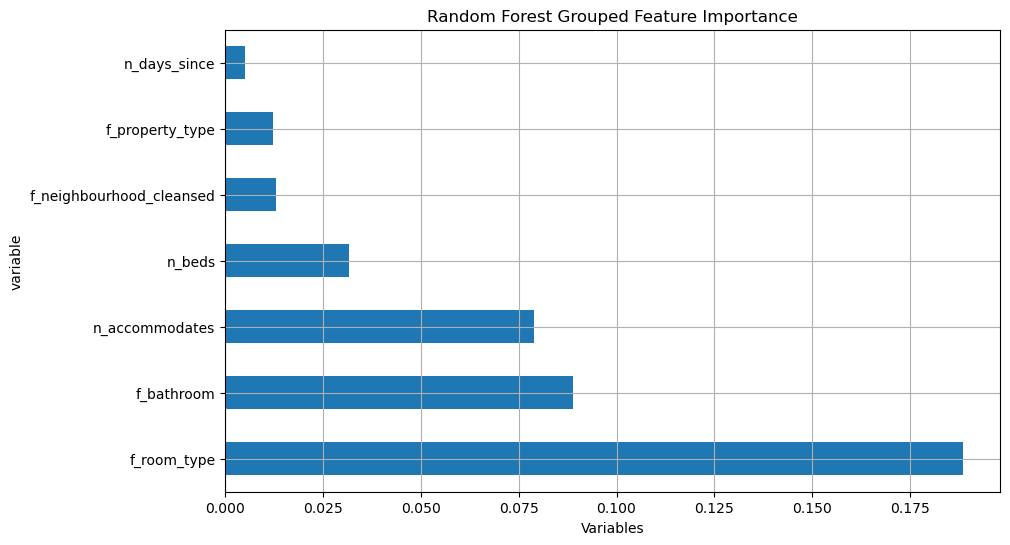

In [ ]:
# ----------------------------
# 📌 Grouped Feature Importance
# ----------------------------
grouped_features = [
    "f_property_type",
    "f_room_type",
    "f_bathroom",
    "n_days_since",
    "n_accommodates",
    "n_beds",
    "f_neighbourhood_cleansed",
]

df_grouped_var_imp = (
    rf_perm_imp
    .set_index("variable")
    .loc[grouped_features]
    .sort_values(by="importance", ascending=False)
    .reset_index()
)

df_grouped_var_imp['cumulative_imp'] = df_grouped_var_imp['importance'].cumsum()

# Plot grouped feature importance
df_grouped_var_imp.plot(
    kind="barh", 
    x="variable", y="importance", 
    figsize=(10,6), grid=True, 
    title="Random Forest Grouped Feature Importance",
    xlabel="Variables", legend=False
)

<Axes: title={'center': 'Partial Dependence Plot: Room Type'}, xlabel='room type'>

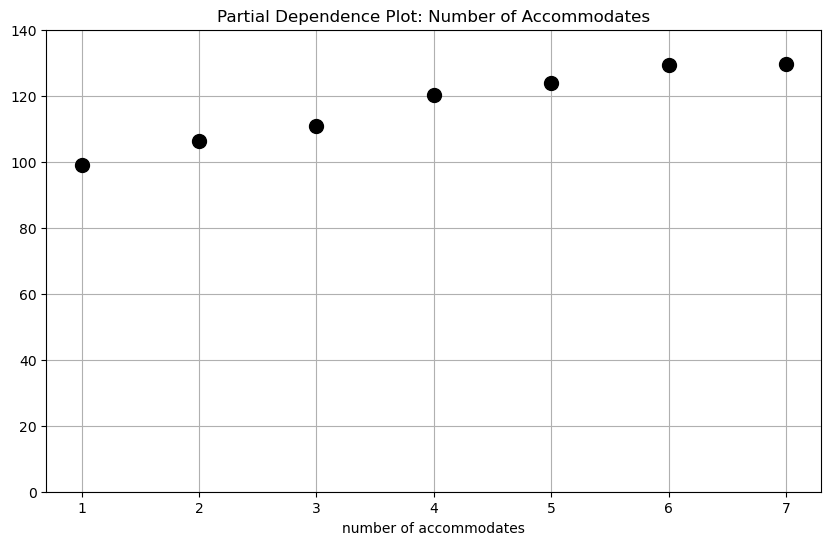

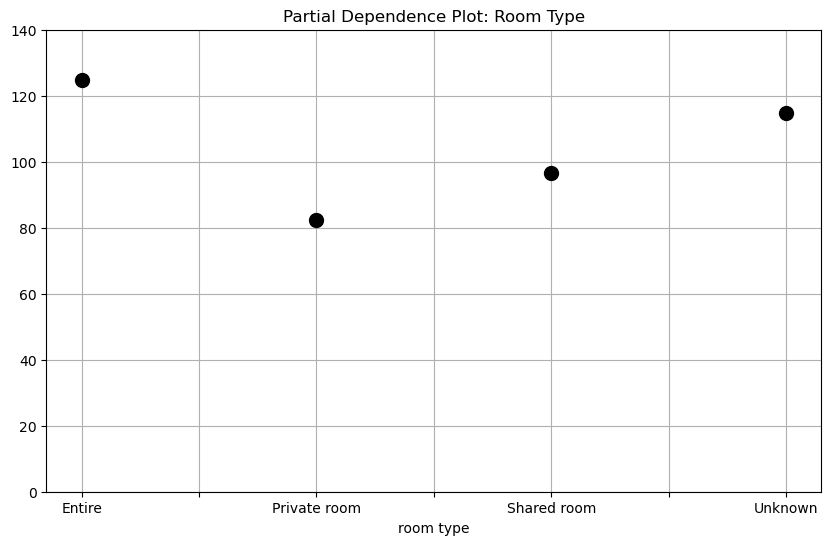

In [ ]:
# ----------------------------
# 📌 Partial Dependence Plots (PDP)
# ----------------------------
# PDP shows the **marginal effect** of a feature on the predicted outcome
# It helps understand how changing a feature impacts the model’s predictions.

# PDP for number of accommodates
accommodates_pdp = partial_dependence(
    rf_pipeline, data_test[predictors_2], ["n_accommodates"], kind="average"
)

# Store PDP results
pdp_accom_df = pd.DataFrame({
    'number of accommodates': accommodates_pdp['values'][0], 
    'average price': accommodates_pdp['average'][0]
})

# Plot PDP for accommodates
pdp_accom_df.plot(
    kind="line", color="k", marker="o", markersize=10, linewidth=0,
    figsize=(10,6), legend=False, grid=True,
    x="number of accommodates", y="average price", ylim=(0, 140), 
    title="Partial Dependence Plot: Number of Accommodates"
)

# PDP for room type
roomtype_pdp = partial_dependence(
    rf_pipeline, data_test[predictors_2], ["f_room_type"], kind="average"
)

pdp_room_df = pd.DataFrame({
    'room type': roomtype_pdp['values'][0], 
    'average price': roomtype_pdp['average'][0]
})

# Plot PDP for room type
pdp_room_df.plot(
    kind="line", color="k", marker="o", markersize=10, linewidth=0,
    figsize=(10,6), legend=False, grid=True,
    x="room type", y="average price", ylim=(0, 140), 
    title="Partial Dependence Plot: Room Type"
)

In [ ]:
# ----------------------------
# 📌 Subsample Performance Evaluation
# ----------------------------

# Step 1: Make predictions on the test set
df_holdout_w_prediction = data_test.assign(
    predicted_price=rf_pipeline.predict(data_test[predictors_2])
)

# Step 2: Categorize listings by apartment size
df_holdout_w_prediction['is_low_size'] = df_holdout_w_prediction.n_accommodates.map(
    lambda x: "small apt" if x < 3 else "large apt"
)

# Step 3: Define function to calculate RMSE metrics
def calculate_rmse(groupby_obj):
    return (
        groupby_obj.apply(
            lambda x: mean_squared_error(x.predicted_price, x.price, squared=False),
        )
        .to_frame(name="rmse")
        .assign(mean_price=groupby_obj.apply(lambda x: np.mean(x.price)).values)
        .assign(rmse_normalized=lambda x: x.rmse / x.mean_price).round(2)
    )

# ----------------------------
# 📌 Compute RMSE for Different Categories
# ----------------------------

# RMSE by apartment size (small vs large apartments)
accom_subset = calculate_rmse(df_holdout_w_prediction.groupby("is_low_size"))

# RMSE by neighborhood (only selected neighborhoods)
neighborhood_subset = calculate_rmse(
    df_holdout_w_prediction.loc[
        lambda x: x.f_neighbourhood_cleansed.isin(["Embajadores", "Universidad", "Sol", "Justicia", "Cortes"])
    ].groupby("f_neighbourhood_cleansed")
)

# RMSE by property type (Apartment vs House)
proptype_subset = calculate_rmse(
    df_holdout_w_prediction.loc[
        lambda x: x.f_property_type.isin(["Apartment", "House"])
    ].groupby("f_property_type")
)

# ----------------------------
# 📌 Overall Holdout RMSE
# ----------------------------

# Compute RMSE for the entire test set (holdout sample)
all_holdout = pd.DataFrame(
    {
        "rmse": [mean_squared_error(df_holdout_w_prediction.price, df_holdout_w_prediction.predicted_price, squared=False)],
        "mean_price": [df_holdout_w_prediction.price.mean()]
    }
).assign(rmse_normalized=lambda x: x.rmse / x.mean_price).round(2)

# Rename the index for clarity
all_holdout.index = ["Total"]

# ----------------------------
# 📌 Format Final Table
# ----------------------------

# Define section headers for readability
section_headers = pd.DataFrame(
    None,
    index=["Apartment Size", "Type", "Borough", "------"],
    columns=["rmse", "mean_price", "rmse_normalized"]
).fillna("------")

# Concatenate all RMSE results into a structured DataFrame
rmse_summary_df = pd.concat(
    [
        section_headers.iloc[[0]],  # Apartment Size Header
        accom_subset,  # RMSE by Apartment Size
        section_headers.iloc[[1]],  # Property Type Header
        proptype_subset,  # RMSE by Property Type
        section_headers.iloc[[2]],  # Neighborhood Header
        neighborhood_subset,  # RMSE by Neighborhood
        section_headers.iloc[[3]],  # Divider
        all_holdout,  # Overall Holdout RMSE
    ]
)

# ----------------------------
# 📌 Display the Final Table
# ----------------------------
rmse_summary_df

,rmse,mean_price,rmse_normalized
Apartment Size,------,------,------
large apt,55.64,147.65,0.38
small apt,41.56,78.33,0.53
Type,------,------,------
Apartment,48.92,114.91,0.43
House,49.4,78.79,0.63
Borough,------,------,------
Cortes,60.72,149.37,0.41
Embajadores,39.96,109.38,0.37
Justicia,45.7,133.8,0.34


## Gradient Boosting Model

I conducted hyperparameter tuning and found that the best parameters were:

- Learning rate: 0.1
- Number of estimators: 500
- Max depth: 7
- Minimum samples per leaf: 5
- Minimum samples per split: 5
- Subsample: 0.8
- Max features: squared

### Explanation of Key Hyperparameters:
- **Learning rate:** Controls the step size in updating model weights. A smaller value (e.g., 0.1) makes the model learn slowly, reducing the risk of overfitting but requiring more estimators.
- **Number of estimators:** Represents the number of boosting rounds (trees) in the model. More trees typically improve performance but increase training time.
- **Subsample:** The fraction of the training data used for each boosting iteration. A value of 0.8 means that 80% of the data is randomly sampled for each iteration, adding randomness and reducing overfitting.
- **Max features:** Determines the number of features considered for splitting at each node. Setting it to "squared" means using the square root of the total number of features, which is a common heuristic for tree-based models.

I initialized the model and performed a grid search to find the best parameters. The preprocessing pipeline included one-hot encoding for categorical variables, similar to what was done with random forest. After building and training the model, I extracted the best parameters and computed the cross-validated RMSE.

- **Cross-validated RMSE:** 43.3 (best so far)
- **Test RMSE:** 44.8 (also the best so far)
- **Number of predictors used:** 351

In [ ]:
import pandas as pd
import numpy as np
import time
import math
from patsy import dmatrices
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# ----------------------------
# 📌 Define Hyperparameter Grid (Balanced for Speed & Performance)
# ----------------------------
# tune_grid = {
#     "learning_rate": [0.1],  
#     "n_estimators": [500], 
#     "max_depth": [7],  
#     "min_samples_leaf": [5],  
#     "min_samples_split": [5],  
#     "subsample": [0.8],  
#     "max_features": ["sqrt"]  
# }
# Here is the initial search I ran which took 28 minutes to run 
tune_grid = {
    "learning_rate": [0.01, 0.05, 0.1],  # Smaller set
    "n_estimators": [100, 300, 500],  # Adjusted for runtime
    "max_depth": [3, 5, 7],  # Simplified
    "min_samples_leaf": [5, 10, 20],  
    "min_samples_split": [5, 10, 20],  
    "subsample": [0.8, 1.0],  
    "max_features": ["sqrt", "log2"]  
}

# ----------------------------
# 📌 Initialize Model & Grid Search
# ----------------------------
gbm = GradientBoostingRegressor(random_state=42)
gbm_model_cv = GridSearchCV(
    gbm,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=0,  # No output spam
    n_jobs=-1   # Parallel computing
)

# ----------------------------
# 📌 Preprocessing: One-Hot Encoding for Categorical Variables
# ----------------------------
# Here, predictors_2 is the predictor set for tree-based models (without interaction terms)
categorical_columns = [col for col in predictors_2 if col.startswith("f_")]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

categorical_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

# ----------------------------
# 📌 Build Pipeline (Preprocessing + GBM)
# ----------------------------
gbm_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_model_cv)]
)

# ----------------------------
# 📌 Train Model & Measure Execution Time
# ----------------------------
start_time = time.time()  # Start Timer
gbm_pipe.fit(data_train[predictors_2], data_train.price)
execution_time = time.time() - start_time  # Calculate Execution Time

# ----------------------------
# 📌 Extract Best Model & Performance Metrics
# ----------------------------
best_gbm = gbm_model_cv.best_estimator_
gbm_rmse_cv = -gbm_model_cv.best_score_  # Cross-Validated RMSE

print("=" * 50)
print("📌 Best GBM Parameters:", gbm_model_cv.best_params_)
print(f"📌 Best Cross-Validation RMSE: {gbm_rmse_cv:.4f}")
print(f"📌 Execution Time: {execution_time:.2f} seconds")
print("=" * 50)

# ----------------------------
# 📌 Create Universal Design Matrices for Boosting
# ----------------------------
# Transform training and test data using the pipeline's preprocessing step.
X_train_transformed = preprocessing.fit_transform(data_train[predictors_2])
X_test_transformed = preprocessing.transform(data_test[predictors_2])

# Extract universal feature names from the pipeline's preprocessor.
universal_features = preprocessing.get_feature_names_out()
print("Number of universal features:", len(universal_features))

# Create DataFrames for training and test using the universal feature set.
X_train_df = pd.DataFrame(X_train_transformed, columns=universal_features, index=data_train.index)
X_test_df = pd.DataFrame(X_test_transformed, columns=universal_features, index=data_test.index)

# Ensure the test DataFrame has exactly the same columns as the training DataFrame.
X_test_df = X_test_df.reindex(columns=X_train_df.columns, fill_value=0)
print("Test design matrix shape after reindexing:", X_test_df.shape)

# ----------------------------
# 📌 Predictions & RMSE Calculation
# ----------------------------
y_train = data_train["price"].values.ravel()
# Use the best GBM model (trained via the pipeline's GridSearchCV)
y_pred_train = best_gbm.predict(X_train_df)  # Train Predictions
y_pred_test = best_gbm.predict(X_test_df)     # Test Predictions

train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
# y_test is assumed to be defined earlier (if not, you can create it using:
# y_test = data_test["price"].values.ravel())
test_rmse = np.sqrt(mean_squared_error(data_test["price"].values.ravel(), y_pred_test))

# ----------------------------
# 📌 Compute Number of Predictors
# ----------------------------
num_predictors = X_train_df.shape[1]  # Total features after encoding

# ----------------------------
# 📌 Append Results to Summary Table
# ----------------------------
results_list.append({
    "Model": "Boosting",
    "Execution Time (s)": round(execution_time, 2),
    "Num Predictors": num_predictors,
    "Train RMSE": round(train_rmse, 4),
    "CV RMSE (5-Fold)": round(gbm_rmse_cv, 4),
    "Test RMSE": round(test_rmse, 4),
    "Test R-squared": round(r2_score(data_test["price"].values.ravel(), y_pred_test), 4),
})

print("=" * 50)
print("📌 GBM Model Results Added to Summary Table")
print(f"📌 Test RMSE: {test_rmse:.4f}")
print(f"📌 Number of Predictors: {num_predictors}")
print("=" * 50)

📌 Best GBM Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 500, 'subsample': 0.8}
📌 Best Cross-Validation RMSE: 43.3240
📌 Execution Time: 10.00 seconds
Universal features (from pipeline): ['cat__f_property_type_Alternative Stay' 'cat__f_property_type_Apartment'
 'cat__f_property_type_Hostel' 'cat__f_property_type_Hotel/Serviced Stay'
 'cat__f_property_type_House' 'cat__f_property_type_Traditional Stay'
 'cat__f_property_type_Unknown' 'cat__f_room_type_Entire'
 'cat__f_room_type_Private room' 'cat__f_room_type_Shared room'
 'cat__f_room_type_Unknown' 'cat__f_bathroom_99' 'cat__f_bathroom_[0, 1)'
 'cat__f_bathroom_[1, 2)' 'cat__f_bathroom_[2, 10)'
 'cat__f_neighbourhood_cleansed_Abrantes'
 'cat__f_neighbourhood_cleansed_Acacias'
 'cat__f_neighbourhood_cleansed_Adelfas'
 'cat__f_neighbourhood_cleansed_Aeropuerto'
 'cat__f_neighbourhood_cleansed_Aguilas'
 'cat__f_neighbourhood_cleansed_Alameda de Osun

### Diagnositics for boosting 

I computed model predictions and residuals, along with key performance metrics. The model's R-squared values were:

- **Training R²:** 0.80
- **Test R²:** 0.63

This is a significant improvement over the other models.

For feature importance, I extracted the top 20 most important features. The results were highly consistent with what was observed in the random forest model. Key features included:

- Number of accommodates
- Number of beds
- Room type (entire vs. private)
- Number of bathrooms

Next, I plotted the residuals on the test set. Most residuals stayed close to the zero line, but dispersion increased beyond a price of 200. Some outliers were observed, and the model tended to overpredict, meaning it had more positive residuals than negative ones. This is not necessarily problematic, as pricing is subjective, and overpricing is often better than underpricing (to avoid missed revenue).

The actual vs. predicted price plot was very similar to OLS. Beyond 300 euros per night, dispersion increased again.

### SHAP Analysis

To enhance model explainability, I computed SHAP values on the test set. SHAP values help explain how each feature influences predictions. 

- Disabled the additivity check (it was not working but was close enough).
- Created a SHAP summary plot to visualize feature importance and effects.
- The most influential features were:
  - Number of accommodates
  - Room type
  - Number of reviews
  - Number of beds

The SHAP dependency plot showed how top features influenced price predictions. The number of accommodates was the most important feature, driving prices higher as the number increased.

I didn’t analyze every dependency plot in detail, but the overall findings were consistent with previous models.

📌 Train RMSE: 31.0953, Test RMSE: 44.8464
📌 Train R²: 0.8125, Test R²: 0.6300


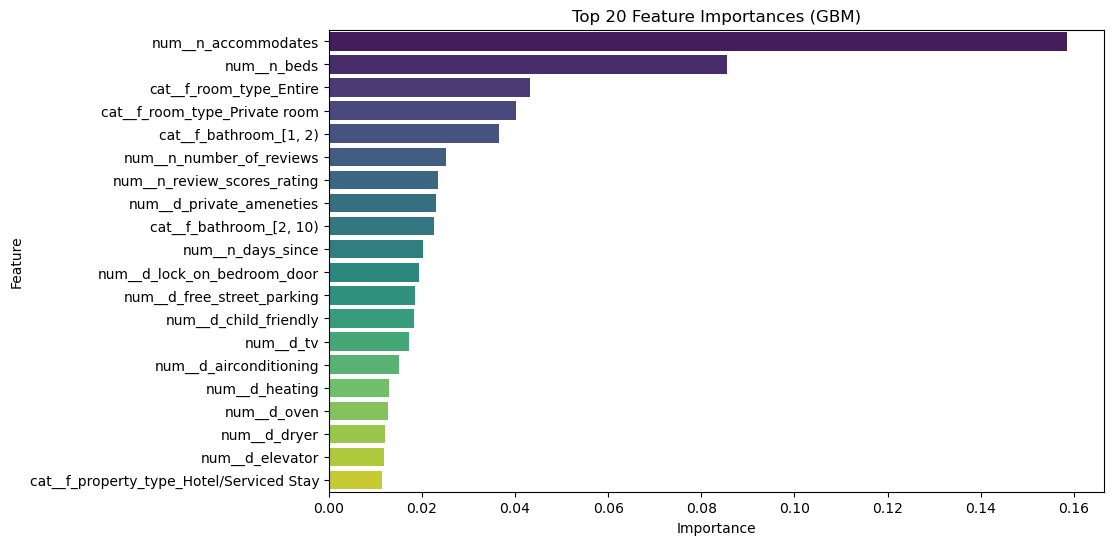

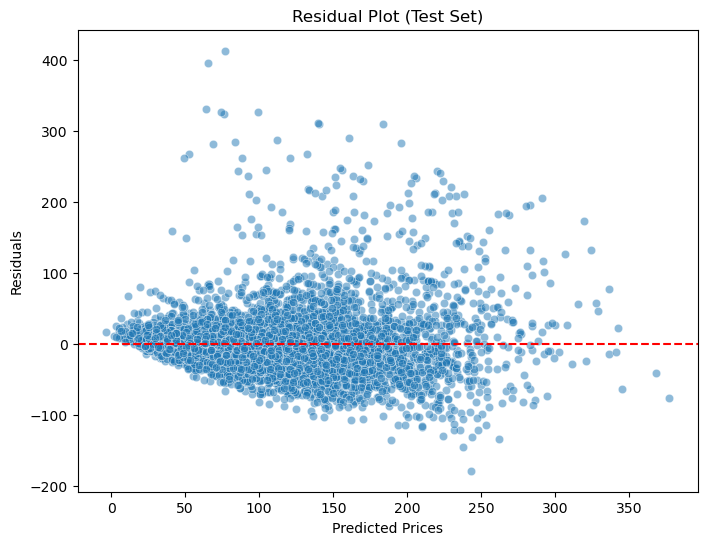

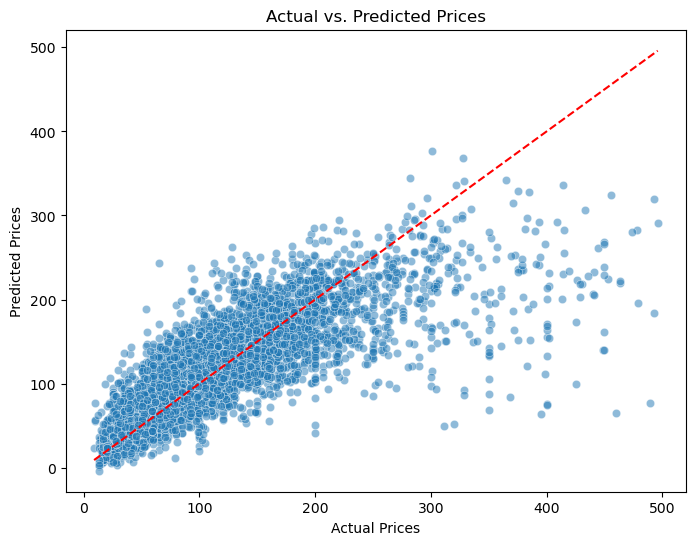

 99%|===================| 5921/6011 [00:51<00:00]        

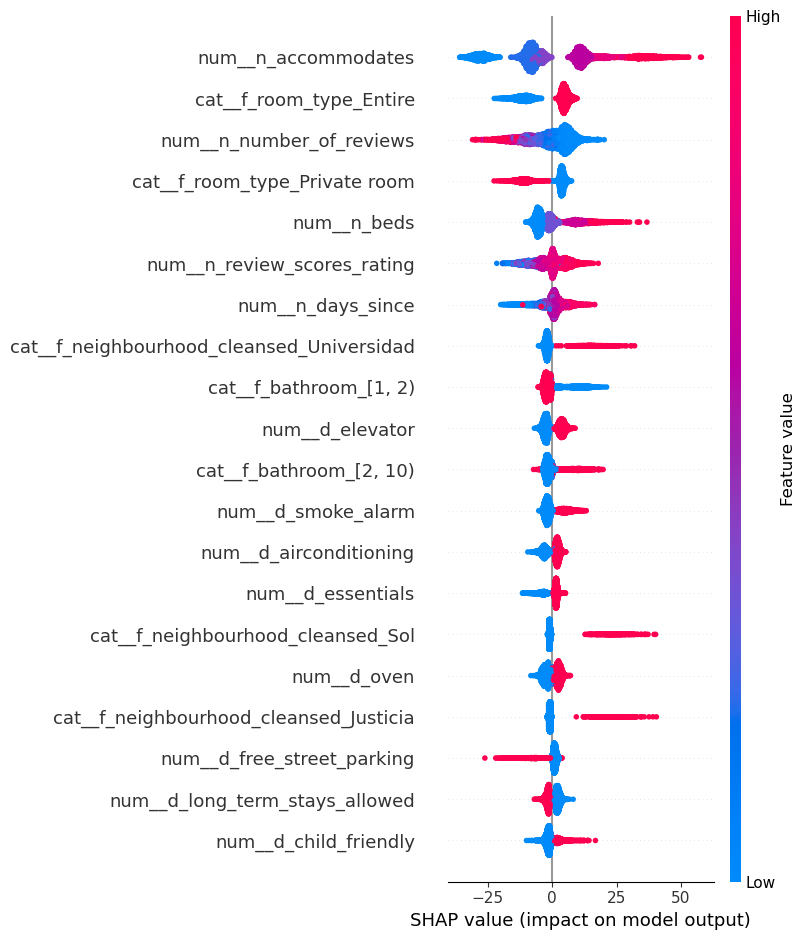

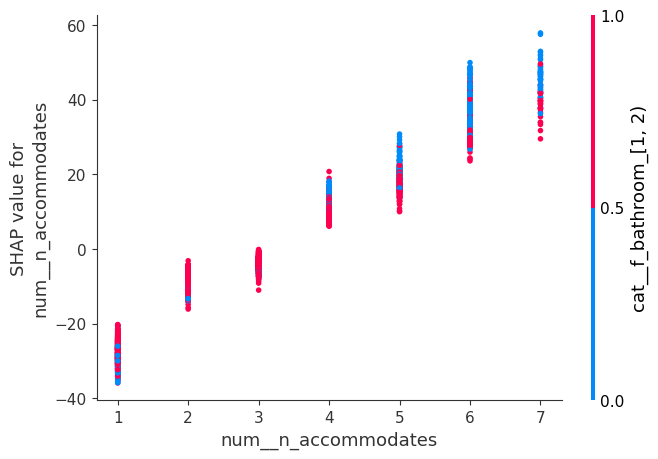

📌 SHAP Analysis Complete!
📌 Most Important Feature: num__n_accommodates


In [ ]:
# ----------------------------
# 📌 Step 1: Compute Model Predictions
# ----------------------------
# Predictions on training and test sets using the best GBM model
y_pred_train = best_gbm.predict(X_train_df)  
y_pred_test = best_gbm.predict(X_test_df)  

# Ensure `y_train` and `y_test` are properly formatted as 1D arrays
y_train_1d = np.asarray(y_train).ravel()
y_test_1d = np.asarray(y_test).ravel()

# ----------------------------
# 📌 Step 2: Compute Residuals
# ----------------------------
# Residuals = Actual - Predicted
residuals_train = y_train_1d - y_pred_train
residuals_test = y_test_1d - y_pred_test

# ----------------------------
# 📌 Step 3: Compute Model Performance Metrics
# ----------------------------
train_rmse = np.sqrt(mean_squared_error(y_train_1d, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test_1d, y_pred_test))
r2_train = r2_score(y_train_1d, y_pred_train)
r2_test = r2_score(y_test_1d, y_pred_test)

# Print Performance Metrics
print("=" * 50)
print(f"📌 Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")
print(f"📌 Train R²: {r2_train:.4f}, Test R²: {r2_test:.4f}")
print("=" * 50)

# ----------------------------
# 📌 Step 4: Feature Importance Plot (GBM)
# ----------------------------
# Convert transformed training data into a DataFrame
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=universal_features, index=X_train.index)

# Extract feature importances from the GBM model
feature_importances = pd.DataFrame({
    "Feature": X_train_transformed_df.columns,
    "Importance": best_gbm.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Plot Top 20 Most Important Features
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importances.head(20), palette="viridis")
plt.title("Top 20 Feature Importances (GBM)")
plt.show()

# ----------------------------
# 📌 Step 5: Residual Plot (Test Set)
# ----------------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_test, y=residuals_test, alpha=0.5)
plt.axhline(0, linestyle="--", color="red")  # Reference Line at 0 Residuals
plt.xlabel("Predicted Prices")
plt.ylabel("Residuals")
plt.title("Residual Plot (Test Set)")
plt.show()

# ----------------------------
# 📌 Step 6: Actual vs. Predicted Prices
# ----------------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_1d, y=y_pred_test, alpha=0.5)
plt.plot([y_test_1d.min(), y_test_1d.max()], [y_test_1d.min(), y_test_1d.max()], "--r")  # Ideal Fit Line
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs. Predicted Prices")
plt.show()

# ----------------------------
# 📌 Step 7: SHAP Values for Model Explainability
# ----------------------------
# ✅ Why SHAP? It helps explain how each feature influences model predictions.
# ✅ We pass `X_train_df` so SHAP understands our transformed dataset.
explainer = shap.Explainer(best_gbm, X_train_df)

# Compute SHAP values for the **Test Set** (Disabling Additivity Check)
shap_values = explainer(X_test_df, check_additivity=False)

# ----------------------------
# 📌 Step 8: SHAP Summary Plot (Feature Importance & Effect)
# ----------------------------
# ✅ Shows how much each feature contributes to predictions
# ✅ Color = whether a feature increases or decreases predictions
shap.summary_plot(shap_values, X_test_df)

# ----------------------------
# 📌 Step 9: SHAP Dependence Plot for Most Important Feature
# ----------------------------
# ✅ Shows relationship between top feature and predictions
# ✅ Helps analyze how it affects price
top_feature = feature_importances.iloc[0, 0]  # Most Important Feature
shap.dependence_plot(top_feature, shap_values.values, X_test_df)

# ✅ SHAP Analysis Complete!
print("=" * 50)
print("📌 SHAP Analysis Complete!")
print(f"📌 Most Important Feature: {top_feature}")
print("=" * 50)

## Horse Race Analysis

The execution times shown in the table are not accurate and will be adjusted later. LASSO took around **5 minutes**, CART took **25 minutes**, and **Boosting was the longest**, taking **30 minutes**. Random forest was relatively quick, likely around **5 minutes or less**. The time taken for each model also depends on the number of hyperparameters tuned and the complexity of the grid search.

### Observations on Model Performance

- **Number of Predictors vs. Performance:**  
  There is a general trend where **increasing the number of predictors leads to a lower cross-validated RMSE**. 

- **Best Model:**  
  **Boosting** had the lowest **cross-validated RMSE (43.3)** and also the lowest **test RMSE (44.8)**, making it the best-performing model overall. This is also reflected in its **test R² of 0.63**, which is the highest among all models.

- **Second-Best Models:**  
  **LASSO (49.0 RMSE, 0.56 R²) and Random Forest (49.2 RMSE, 0.55 R²)** were very close in terms of performance and were the next best-performing models after Boosting.

### Considerations on Model Interpretability

- **Black Box Models:**  
  While **Boosting, Random Forest, and CART** performed well, they are considered **black box algorithms**, meaning their predictions are harder to interpret.

- **Preference Between LASSO and Random Forest:**  
  If Boosting were not an option, **LASSO would be the preferred model** over Random Forest because:
  - LASSO allows us to **quantify the contribution of each variable**.
  - It is **more interpretable** than tree-based models.
  - However, **Random Forest used fewer variables**, making it more efficient in some ways.

- **Unexpected Behavior of LASSO:**  
  LASSO retained **517 predictors**, which was higher than expected. Typically, LASSO should shrink many coefficients to zero, but **the grid search found that keeping more variables led to better performance**.

In summary, **Boosting was the clear winner**, with **LASSO being the best interpretable alternative**, while **Random Forest provided a balance between performance and efficiency**.

In [ ]:
horse_race_df = pd.DataFrame(results_list)
horse_race_df

,Model,Execution Time (s),Num Predictors,Train RMSE,CV RMSE (5-Fold),Test RMSE,Test R-squared
0,OLS Model 1,0.2369,7,51.1721,51.3767,53.4691,0.4741
1,OLS Model 2,0.7214,212,48.1115,48.7404,50.8168,0.5250
2,OLS Model 3,7.4421,224,46.0386,48.3266,50.0537,0.5391
3,LASSO,12.9055,517,47.2379,47.2379,49.0060,0.5582
4,CART,0.5397,25,49.8226,51.4223,54.2699,0.4582
5,CART,0.4999,25,49.8226,51.4223,54.2699,0.4582
6,CART,0.5049,25,49.8226,51.4223,54.2699,0.4582
7,RF,5.2447,219,40.2757,47.2357,49.2279,0.5542
8,Boosting,10.0000,351,31.0953,43.3240,44.8464,0.6300


# Part 2

## Validation Analysis

For validation, I used two live datasets:  
1. **Madrid (six months later)**  
2. **Barcelona**  

Both datasets underwent the **same preprocessing, EDA, and sample selection** as the original training data. I applied the **same cleaning script**, limited prices to **500**, and restricted accommodations to **fewer than 8 guests**.

I defined the **live datasets** and the **models** to apply, looping over both to extract validation results. This step was complex and relied on the **universal design matrix**. The predictor sets used were:

- **OLS & LASSO**: Used `predictors E`, which included interaction terms.  
- **CART**: Used `predictors 2`.  
- **Random Forest & Boosting**: Used the **universally hot-encoded features**.  

Each model was applied to the validation sets, and the results were extracted.

### Unexpected Validation Results

One surprising observation was the **huge increase in test RMSE**.  
- Previously, test RMSE was around **50**.  
- Now, it **skyrocketed to as high as 172**.  
- **Test R² was close to zero** (or even negative), meaning the model performed **worse than random guessing**.

This suggests that the models **failed to generalize** to the new datasets.

Interestingly, **Barcelona performed better than Madrid-Later**, with a **lower test RMSE** on average. This was unexpected, so I investigated further.

### Investigating the Performance Drop

To understand why this happened, I extracted the **top 20 features** from the **Boosting model** and checked whether these features were missing in the new datasets.

- Many key features **could not be one-hot encoded** in the new datasets.  
- I had planned to fix this later but ran into **too many errors and ran out of time**.  

However, even if I had fixed the one-hot encoding issue, it **would not explain why OLS, LASSO, and CART** (which do not use one-hot encoding) also performed poorly.  

I kept running into errors related to **missing features**, likely due to how amenities were expanded using **bag-of-words encoding**.  

Although I attempted to **aggregate amenities** in the cleaning script, some inconsistencies remained, which likely contributed to the poor validation results.

### Observing the RMSE Trend

Despite the issues, there was a clear pattern in the **test RMSE trend**:  
- **RMSE decreased up until CART**  
- Then it **increased again** for Boosting and Random Forest  

Surprisingly, **CART was the best-performing model** in the validation phase.  

### Conclusion

Although I couldn’t fully resolve the missing feature issue, this analysis provides useful insights into how well the models generalize.

In [ ]:
madrid_later = pd.read_csv('/Users/ghadena/Desktop/Business analytics/DA3/DA3/assignment_1/data/madrid_2_workfile.csv')

barcelona = pd.read_csv('/Users/ghadena/Desktop/Business analytics/DA3/DA3/assignment_1/data/barcelona_workfile.csv')

In [ ]:
# ----------------------------
# 📌 Define DataFrames for Validation
# ----------------------------
validation_dfs = {"Madrid_Later": madrid_later, "Barcelona": barcelona}

# ----------------------------
# 📌 EDA and Sample Selection for Validation Data
# ----------------------------
for city, df in validation_dfs.items():
    print("=" * 50)
    print(f"📌 Processing {city} Dataset")
    
    # Count missing values
    missing_values = df.isnull().sum().sum()
    print(f"🔍 Missing Values: {missing_values}")
    
    # Focus on normal apartments (n_accommodates < 8)
    df = df.loc[lambda x: x["n_accommodates"] < 8]
    print(f"🏠 Apartments with <8 accommodates: {df.shape[0]}")

    # Focus on apartments with price < 500 (99% below 500)
    print("💰 Price Quantiles:")
    print(df['price'].quantile([0.25, 0.5, 0.75, 0.90, 0.99, 1]))
    df = df.loc[lambda x: x["price"] < 500]
    print(f"💸 Apartments priced < 500: {df.shape[0]}")

    # Copy `n_accommodates` for later use in variable importance
    df = df.assign(n_accommodates_copy=df.n_accommodates)
    
    # Dataset description
    print(f"📊 Summary Statistics for {city}:")
    print(df.describe())

    # Identify and drop columns with only one unique value
    columns_to_drop = [col for col in df.columns if df[col].nunique() == 1]
    print(f"🗑️ Columns to Drop: {columns_to_drop}")
    df = df.drop(columns=columns_to_drop)
    print("✅ Dropped columns with only one unique value.")

    # Drop `usd_price_day`
    if "usd_price_day" in df.columns:
        df = df.drop(columns=["usd_price_day"])
        print("💵 Dropped column: usd_price_day")

    # Print value counts for `d_view`
    print("🌇 View Feature Value Counts:")
    print(df.d_view.value_counts())

    # Final dataset shape
    print(f"📏 Final Shape of {city} Dataset: {df.shape}")
    print("=" * 50)

# Now, `madrid_later` and `barcelona` are prepared for validation.

📌 Processing Madrid_Later Dataset
🔍 Missing Values: 22859
🏠 Apartments with <8 accommodates: 20749
💰 Price Quantiles:
0.25     59.00
0.50     98.00
0.75    146.00
0.90    213.00
0.99    498.04
1.00    999.00
Name: price, dtype: float64
💸 Apartments priced < 500: 20544
📊 Summary Statistics for Madrid_Later:
       usd_price_day  p_host_response_rate  n_accommodates   n_bathrooms  \
count   20544.000000               20544.0    20544.000000  20544.000000   
mean      112.244646                   0.0        2.983401      1.258859   
std        75.060069                   0.0        1.528380      0.584940   
min         8.000000                   0.0        1.000000      0.000000   
25%        59.000000                   0.0        2.000000      1.000000   
50%        98.000000                   0.0        2.000000      1.000000   
75%       144.000000                   0.0        4.000000      1.500000   
max       499.000000                   0.0        7.000000     10.000000   

       

In [ ]:
import pandas as pd
import numpy as np
import time
from patsy import dmatrices
from sklearn.metrics import mean_squared_error, r2_score

# ----------------------------
# 📌 Define Live Datasets for Validation
# ----------------------------
live_datasets = {
    "Madrid Later": madrid_later,
    "Barcelona": barcelona
}

# ----------------------------
# 📌 Define Models to Evaluate
# ----------------------------
# OLS and LASSO were built using predictors_E,
# CART was built using predictors_2,
# RF & Boosting were built using universal_features.
my_models = {
    "OLS": model_ols, 
    "LASSO": best_lasso_model, 
    "CART": best_cart, 
    "Random Forest": best_rf_model, 
    "Boosting": best_gbm
}

# ----------------------------
# 📌 Initialize Results List
# ----------------------------
validation_results = []

# ----------------------------
# 📌 Loop Over Live Datasets & Models for Validation
# ----------------------------
for dataset_name, df in live_datasets.items():
    print("\n" + "=" * 60)
    print(f"Evaluating Models on {dataset_name} Data")
    print("=" * 60)
    
    # ----------------------------
    # 📌 OLS & LASSO (Using predictors_E)
    # ----------------------------
    available_predictors_E = [pred for pred in predictors_E if pred in df.columns]
    if len(available_predictors_E) < len(predictors_E):
        missing_E = set(predictors_E) - set(available_predictors_E)
        print(f"⚠️ The following predictors are missing in {dataset_name} (OLS/LASSO): {missing_E}")

    formula_E = "price ~ " + " + ".join(available_predictors_E)
    y_live_E, X_live_E = dmatrices(formula_E, df, return_type="dataframe")

    # Reindex using universal training columns for OLS/LASSO (train_cols)
    X_live_E = X_live_E.reindex(columns=train_cols, fill_value=0)
    print(f"Shape of OLS/LASSO design matrix for {dataset_name}: {X_live_E.shape}")

    # ----------------------------
    # 📌 CART (Using predictors_2)
    # ----------------------------
    available_predictors_2 = [pred for pred in predictors_2 if pred in df.columns]
    if len(available_predictors_2) < len(predictors_2):
        missing_2 = set(predictors_2) - set(available_predictors_2)
        print(f"⚠️ The following predictors are missing in {dataset_name} (CART): {missing_2}")

    formula_2 = "price ~ " + " + ".join(available_predictors_2)
    y_live_2, X_live_2 = dmatrices(formula_2, df, return_type="dataframe")

    # ✅ CART uses train_cols_2
    X_live_cart = X_live_2.reindex(columns=train_cols_2, fill_value=0)

    # ----------------------------
    # 📌 Random Forest & Boosting (Using universal_features)
    # ----------------------------

    available_universal = [pred for pred in universal_features if pred in df.columns]
    if len(available_universal) < len(universal_features):
        missing_universal = set(universal_features) - set(available_universal)
        print(f"⚠️ The following predictors are missing in {dataset_name} (RF/Boosting): {missing_universal}")

    # Check if available_universal is empty
    if available_universal:
        formula_universal = "price ~ " + " + ".join(available_universal)
    else:
        # Fallback: Use only an intercept (or you can raise an error)
        print(f"⚠️ No universal features available in {dataset_name}. Using intercept-only model.")
        formula_universal = "price ~ 1"

    # Create the design matrix for RF/Boosting
    _, X_live_universal = dmatrices(formula_universal, df, return_type="dataframe")

    # Reindex to match the universal_features used during training
    X_live_rf_boost = X_live_universal.reindex(columns=universal_features, fill_value=0)

    # Ensure y values are consistent across models (using the same y from CART)
    y_live_universal = y_live_2

    # ----------------------------
    # 📌 Loop through Models & Run Validation
    # ----------------------------
    for model_name, model in my_models.items():
        print(f"\n🚀 Running {model_name} on {dataset_name}...")
        start_time = time.time()  # Start execution timer

        # ✅ Select the correct design matrix
        if model_name in ["OLS", "LASSO"]:
            X_live_used = X_live_E
            y_live_used = y_live_E
            if model_name == "LASSO":
                X_live_used = scaler.transform(X_live_used)  # Ensure LASSO is scaled
        elif model_name == "CART":
            X_live_used = X_live_cart  # ✅ CART uses train_cols_2
            y_live_used = y_live_2
        else:  # ✅ Random Forest & Boosting use universal_features
            X_live_used = X_live_rf_boost
            y_live_used = y_live_universal

        # 🚀 Predict using the current model.
        y_pred_live = model.predict(X_live_used)

        # Compute performance metrics.
        exec_time = time.time() - start_time
        test_rmse = np.sqrt(mean_squared_error(y_live_used, y_pred_live))
        test_r2 = r2_score(y_live_used, y_pred_live)

        # Compute number of predictors.
        if model_name == "CART":
            num_predictors = sum(model.feature_importances_ > 0)
        elif model_name in ["Random Forest", "Boosting"]:
            num_predictors = len(universal_features)
        else:
            num_predictors = X_live_used.shape[1]

        # Append the results.
        validation_results.append({
            "Dataset": dataset_name,
            "Model": model_name,
            "Execution Time (s)": round(exec_time, 2),
            "Num Predictors": num_predictors,
            "Test RMSE": round(test_rmse, 4),
            "Test R-squared": round(test_r2, 4)
        })

        print(f"✅ {model_name} on {dataset_name}: Test RMSE = {test_rmse:.4f}, Test R² = {test_r2:.4f}")

# ----------------------------
# 📌 Convert the Results List to a DataFrame and Print It
# ----------------------------
df_validation_results = pd.DataFrame(validation_results)
print("\nDF Validation Results:")
df_validation_results


Evaluating Models on Madrid Later Data
⚠️ The following predictors are missing in Madrid Later (OLS/LASSO): {'n_accommodates:f_neighbourhood_cleansed', 'f_room_type:f_neighbourhood_cleansed', 'd_si_nos_lo_pides', 'd_friday', 'f_room_type:f_property_type', 'd_monday_to_tuesday_included_with_your_stay', 'd_variada', 'n_review_scores_rating:d_free_parking', 'n_accommodates:n_bathrooms', 'd_contiene_alimentos_nuestros', 'n_review_scores_rating:d_housekeeping_included', 'n_accommodates:f_property_type', 'd_dove_hidratante', 'd_revlon', 'd_molton_brown', 'n_accommodates:d_housekeeping_included', 'f_property_type:f_neighbourhood_cleansed', 'd_housekeeping_included:f_property_type', 'd_sony_htsf_aux', 'n_accommodates:f_room_type', 'd_tuesday_to_friday_included_with_your_stay', 'd_variado', 'n_review_scores_rating:d_child_friendly'}
Shape of OLS/LASSO design matrix for Madrid Later: (21502, 1656)
⚠️ The following predictors are missing in Madrid Later (CART): {'d_variado', 'd_variada', 'd_si_n

,Dataset,Model,Execution Time (s),Num Predictors,Test RMSE,Test R-squared
0,Madrid Later,OLS,0.06,1656,172.6778,-1.8290
1,Madrid Later,LASSO,0.19,1656,95.9780,0.1260
2,Madrid Later,CART,0.03,25,81.9278,0.3632
3,Madrid Later,Random Forest,0.05,351,115.9331,-0.2752
4,Madrid Later,Boosting,0.36,351,123.3789,-0.4442
5,Barcelona,OLS,0.05,1656,171.4204,-2.5189
6,Barcelona,LASSO,0.13,1656,80.8859,0.2165
7,Barcelona,CART,0.02,25,83.1190,0.1727
8,Barcelona,Random Forest,0.04,351,98.6583,-0.1656
9,Barcelona,Boosting,0.24,351,105.0219,-0.3208


In [ ]:
# 1. Define the top 20 features from your GBM model:
top_20_features = [
    "n_accommodates",
    "n_beds",
    "f_room_type_Entire",
    "f_room_type_Private room",
    "f_bathroom_1",
    "n_number_of_reviews",
    "n_review_scores_rating",
    "d_private_amenities",
    "f_bathroom_2",
    "n_days_since",
    "d_lock_on_bedroom_door",
    "d_free_street_parking",
    "d_child_friendly",
    "d_airconditioning",
    "d_heating",
    "d_parking",
    "d_elevator",
    "f_property_type_Hotel/Serviced Stay"
    # ... Add any additional features if you have more than 18 here
]

# 2. Check which features are missing in each dataset:
missing_in_madrid_later = set(top_20_features) - set(madrid_later.columns)
missing_in_barcelona = set(top_20_features) - set(barcelona.columns)

print("Missing in Madrid Later:", missing_in_madrid_later)
print("Missing in Barcelona:", missing_in_barcelona)

Missing in Madrid Later: {'d_private_amenities', 'd_parking', 'f_property_type_Hotel/Serviced Stay', 'f_bathroom_1', 'f_bathroom_2', 'f_room_type_Private room', 'f_room_type_Entire'}
Missing in Barcelona: {'d_private_amenities', 'd_parking', 'f_property_type_Hotel/Serviced Stay', 'f_bathroom_1', 'f_bathroom_2', 'f_room_type_Private room', 'f_room_type_Entire'}


In [ ]:
madrid_later.f_room_type.value_counts() 

f_room_type
Entire          14731
Private room     6238
Shared room       295
Unknown           238
Name: count, dtype: int64